In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [13]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [14]:
def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train-valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
    
        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader

In [15]:
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [16]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [17]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0., simple_rho=False):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.simple_rho = simple_rho
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        if (self.simple_rho):
            dkl = - rho * torch.log(self.data_rho) - (1-rho) * torch.log(1-self.data_rho)
        else:
            dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
            
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [18]:
models = {'16': Net(16), '32': Net(32), '64': Net(64), 
          '16 simp_rho': Net(16, simple_rho=True), 
          '32 simp_rho': Net(32, simple_rho=True), 
          '64 simp_rho': Net(64, simple_rho=True)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [71]:
def train(epoch, models, log=None, noisy=False, zero_half=False):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        
        train_data = torch.Tensor(np.copy(data))
        if noisy:
            train_data += torch.randn_like(data)           
        if zero_half:
            train_data[:, :, :, :14] = 0                
        
        for model in models.values():
            model.optim.zero_grad()
            output = model(train_data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [20]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [58]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

tensor([[[[-0.8091, -1.1702, -1.9780,  ..., -0.7885,  0.2864, -1.6033],
          [ 0.1785, -0.9363, -0.8276,  ..., -0.8595,  0.5626, -1.4238],
          [ 0.3762, -1.4372, -0.0043,  ..., -2.9271, -0.6183,  1.1697],
          ...,
          [-2.1360, -0.6053,  0.3494,  ..., -0.4272,  0.8691, -0.6829],
          [-1.0673,  0.0939, -0.2683,  ..., -1.0572, -3.0148, -2.4795],
          [-2.1231, -0.7121,  1.0594,  ..., -0.8689, -2.0207, -0.7914]]],


        [[[-0.8713, -1.2494, -0.6349,  ..., -0.6212, -0.3181,  0.7235],
          [-0.5054,  0.3457,  0.5062,  ..., -1.3021, -1.1003, -0.8116],
          [-2.7699,  0.0807, -0.5159,  ...,  0.3335, -0.3407,  0.3572],
          ...,
          [-1.7241, -0.7987, -3.2208,  ..., -0.3765, -1.9204, -0.6763],
          [-1.7701,  0.7948, -0.9758,  ..., -1.3909, -2.4493, -2.1216],
          [-0.8189,  1.0892, -1.2086,  ..., -1.8508,  0.8292, -1.1388]]],


        [[[-0.7930,  0.5368, -0.5747,  ..., -0.6391, -1.7849,  0.7249],
          [-0.9412, -0.751

tensor([[[[-0.7878, -0.3813, -2.9286,  ..., -1.5430, -2.2776, -2.1717],
          [-1.6345, -2.2091,  0.3630,  ..., -1.9569, -1.5407, -2.0756],
          [-1.9813, -2.4839,  0.1560,  ..., -1.7693,  0.3146, -0.5666],
          ...,
          [-0.3984, -1.2167, -1.5117,  ..., -1.8322, -2.6227, -1.4146],
          [-0.9345, -0.8931, -1.2238,  ..., -0.9121, -1.4004, -1.0417],
          [-0.9768, -3.2811, -1.0271,  ..., -1.9135, -0.6937, -1.1989]]],


        [[[-1.1031, -1.1491, -2.0213,  ...,  1.2924, -1.6845, -1.5978],
          [-2.9911, -2.6285, -0.3358,  ..., -1.3519, -0.0855, -3.4575],
          [-3.0347, -2.5317, -1.9172,  ...,  0.5629, -0.7203, -0.9981],
          ...,
          [-0.4359, -3.1439, -1.7956,  ...,  0.2915, -0.8274,  0.5780],
          [-1.8684,  0.8874, -1.5180,  ...,  1.1032, -0.5445, -1.7552],
          [-0.0918, -1.4398, -1.8366,  ...,  0.1374, -1.6519,  0.5210]]],


        [[[-0.8358,  0.3590, -0.9326,  ..., -0.9242, -0.0302, -0.1068],
          [-0.3828, -1.052

tensor([[[[-2.0192, -2.2744, -0.2505,  ..., -1.5034, -1.3244, -1.3512],
          [ 0.8763, -1.8446, -1.8565,  ..., -0.3892, -0.0728, -2.6924],
          [-1.8064, -0.6167, -1.5621,  ..., -0.5785, -1.7987,  0.7646],
          ...,
          [-1.3306, -1.5758, -0.2582,  ...,  0.1107, -0.6800, -1.9382],
          [-1.1866, -1.1756, -0.8208,  ..., -0.9580,  0.5625,  0.1870],
          [-1.5807, -0.3303,  0.0238,  ..., -0.9187, -0.7906, -2.7521]]],


        [[[-1.6753,  0.2762,  1.4644,  ..., -2.4772, -0.0848, -2.1870],
          [ 0.6651, -0.8651, -1.3680,  ..., -0.5678, -2.0083, -2.9000],
          [ 0.2699, -1.0590,  0.1107,  ..., -0.2537, -0.9115, -1.8249],
          ...,
          [-1.1693, -1.4691, -0.9595,  ..., -1.7509, -0.6318, -0.8064],
          [-1.0804, -1.4346, -0.8877,  ..., -1.7241, -1.2033, -1.1890],
          [-1.5277, -1.4958, -0.9541,  ..., -0.9080, -2.0573, -0.7517]]],


        [[[-2.5140, -2.6402, -0.9058,  ..., -2.4156, -1.5076, -1.5625],
          [-1.8622,  0.389

tensor([[[[-0.9166, -1.1304, -1.7353,  ..., -1.5614, -1.6321, -0.4484],
          [-1.9653, -0.8673, -2.1799,  ...,  0.9962, -2.4729, -0.7195],
          [-0.5326, -0.9492, -1.5052,  ..., -1.8551, -0.0820, -3.1043],
          ...,
          [-0.8864, -0.3633,  1.9258,  ..., -3.1570, -1.7497, -2.6275],
          [-1.6057, -0.3141, -3.0438,  ..., -0.1425, -1.2293, -1.0533],
          [-0.1235,  0.1157, -0.6101,  ..., -0.9058, -0.4463, -1.8986]]],


        [[[-1.0510, -1.9721, -2.0770,  ..., -3.1315, -0.9800, -0.9950],
          [-2.4988, -1.7591, -0.5951,  ..., -1.2843, -0.5419, -0.3472],
          [-2.5210, -2.1277, -2.1852,  ..., -0.6486,  0.1963, -0.8285],
          ...,
          [ 0.4603, -2.2629, -1.7273,  ...,  0.0617, -0.9829, -2.8621],
          [-1.7502, -1.7419, -1.5541,  ..., -0.6807, -1.1250,  0.0971],
          [-0.9702, -1.8146, -2.1349,  ..., -1.8599, -0.6462, -1.0005]]],


        [[[ 0.7000, -0.7056,  0.5606,  ..., -1.0593, -0.5121, -0.3845],
          [-1.7044, -0.016

tensor([[[[ 0.9778, -0.3073, -1.0506,  ..., -2.6623, -1.2666, -1.8858],
          [-0.3851, -1.0182, -0.2736,  ..., -0.3747, -0.0913, -0.5220],
          [-0.9690, -0.7715, -3.3143,  ..., -0.7461, -0.3822,  1.2125],
          ...,
          [-1.6973, -2.5869, -0.0156,  ..., -1.3813, -2.4333, -0.4895],
          [-0.5175, -1.3425, -1.8914,  ...,  0.9541,  0.8790, -1.5140],
          [-1.3800, -0.8172, -1.3195,  ..., -1.6206, -1.9617, -2.1270]]],


        [[[-1.7280,  0.1670, -0.2242,  ...,  0.3460, -0.9818, -2.1017],
          [-0.6166, -1.1452, -0.2159,  ..., -0.7434, -1.0211, -1.6000],
          [-1.1197,  0.4540, -1.6203,  ..., -0.9530, -1.6430, -1.2641],
          ...,
          [ 0.1462, -0.6115, -2.6570,  ..., -1.8375, -0.7890, -0.1681],
          [-0.2521, -0.2357, -1.9570,  ..., -0.1150,  1.0351, -2.4791],
          [-0.3088, -0.9498, -3.2603,  ..., -0.3013, -1.4477, -0.8350]]],


        [[[-0.0398, -3.2007, -1.5502,  ..., -1.8685, -1.3511,  0.8037],
          [-1.8407, -1.674

tensor([[[[-0.6592, -2.6652,  0.2427,  ..., -1.5340, -0.3326, -1.0958],
          [-0.3843, -0.4019, -1.7074,  ..., -1.9975, -0.4919,  0.3140],
          [ 0.0742, -2.2696, -1.9264,  ...,  0.3187, -1.1876,  0.1250],
          ...,
          [-1.4743, -1.2760,  1.6153,  ..., -0.6509, -3.2636, -2.4314],
          [-0.5308, -1.1530, -1.4299,  ..., -1.9079, -1.0344, -2.7584],
          [ 0.3622, -1.1945, -1.6945,  ..., -1.8054, -0.3156, -1.6526]]],


        [[[-1.2189, -2.7483, -2.6532,  ..., -0.1973, -1.8988,  0.6399],
          [-1.0836, -0.7967,  2.2738,  ..., -4.7694, -2.5527, -1.5069],
          [-1.6706, -0.7714, -0.7652,  ..., -1.8720, -0.1799, -0.7322],
          ...,
          [-2.0884, -1.3391,  0.2279,  ..., -1.5621, -1.3439, -0.9233],
          [-1.9316, -0.2213, -0.5772,  ...,  0.7626, -2.0921, -0.7330],
          [-1.2915, -0.3341, -1.5792,  ..., -0.6435, -1.4291,  1.0137]]],


        [[[-0.8247, -1.5145, -2.1144,  ..., -1.1039,  0.6132, -0.3588],
          [ 1.5541, -0.913

KeyboardInterrupt: 

In [23]:
data, _ = next(iter(test_loader))
output = models['64'](data)
output_rho = models['64 simp_rho'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() #данные с выхода сети
rho_to_plot = output_rho.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64)) # подаем на вход декодера тестовые данные
decoded_rho = models['64 simp_rho'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход сети на тестовых данных
rho_dec_to_plot = ((decoded_rho.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28)) #подаем данные на кодер
    encoded_rho = models['64 simp_rho'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1)) # проверяем количество нейронов, преодолевшишх порог 0,5
    print((encoded_rho > 0.5).sum(1))
    encoded[encoded < 0.5] = 0. # прореживаем нейроны не преодолевшие порог
    encoded_rho[encoded_rho < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    rho_decoded_f = models['64 simp_rho'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход прореженной сети
    rho_f_to_plot = ((rho_decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([2, 5, 2, 5, 3, 3, 4, 2, 1, 3, 4, 4, 3, 5, 3, 3, 4, 3, 4, 2, 4, 4, 1, 4,
        1, 4, 5, 3, 5, 2, 4, 3, 3, 5, 3, 2, 2, 2, 1, 2, 4, 2, 2, 2, 2, 3, 4, 2,
        6, 2])
tensor([3, 3, 3, 3, 4, 2, 3, 2, 5, 5, 6, 3, 2, 4, 2, 2, 4, 4, 3, 2, 4, 3, 3, 1,
        2, 5, 4, 3, 2, 1, 3, 2, 4, 3, 5, 5, 1, 1, 1, 3, 3, 3, 2, 1, 4, 3, 4, 2,
        5, 3])


исходные данные


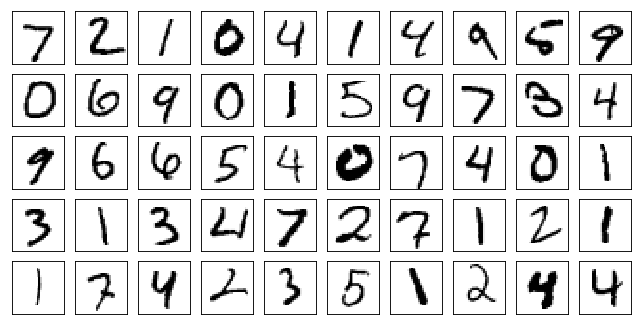

восстановленные данные


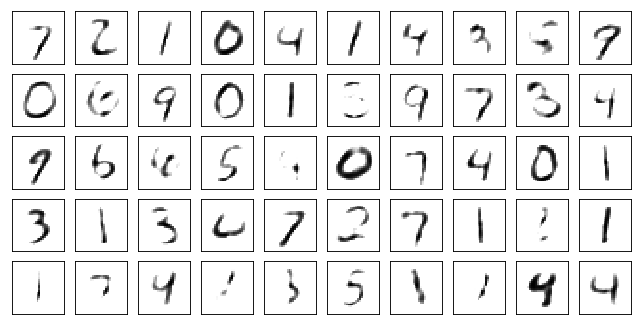

восстановленные данные с упрощенным rho loss


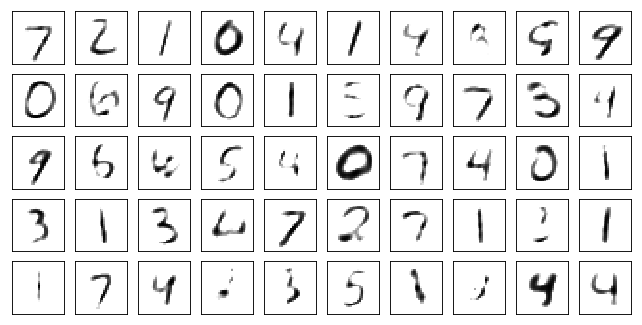

данные на выходе сети с учетом прореживания латентного слоя


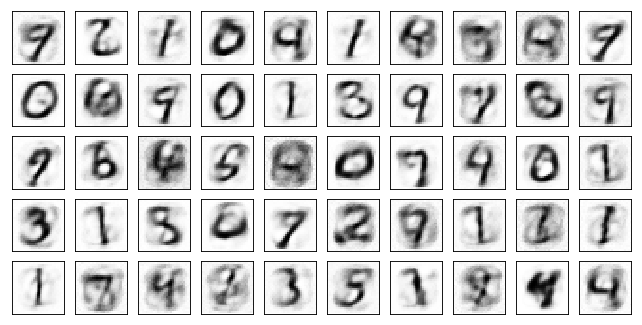

данные на выходе сети с учетом прореживания латентного слоя с упрощенным rho loss


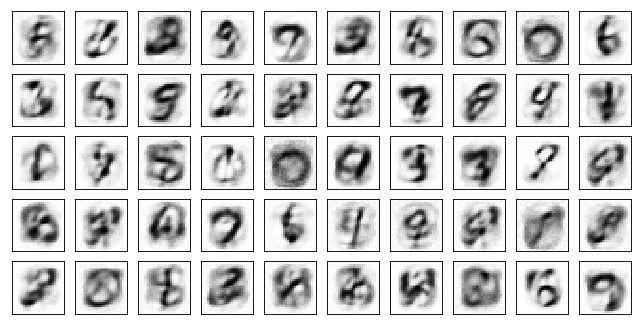

данные на выходе сети при подаче на латентный слой тестовых единичных данных


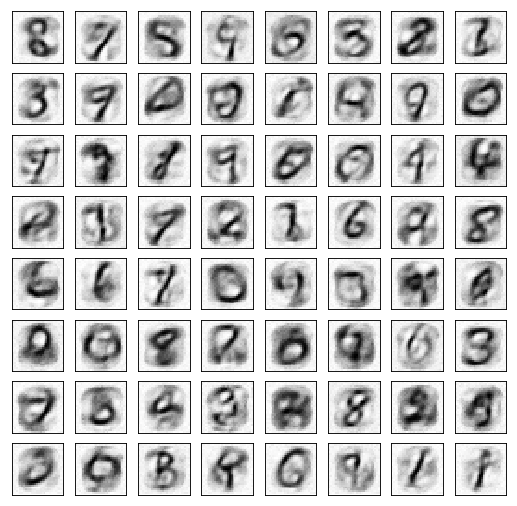

данные на выходе сети при подаче на латентный слой тестовых единичных данных с упрощенным rho loss


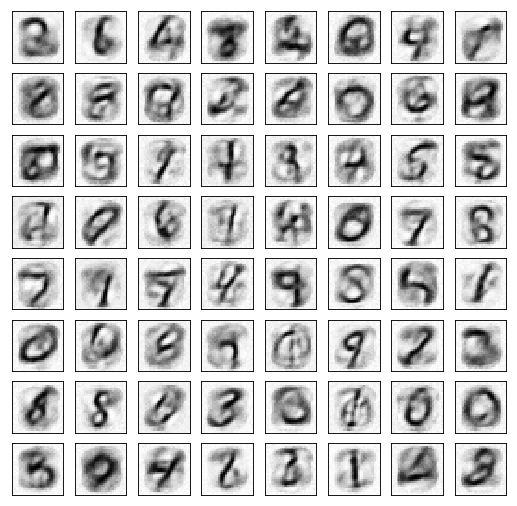

In [24]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))
print('восстановленные данные с упрощенным rho loss')
plot_mnist(rho_to_plot, (5, 10))
print('данные на выходе сети с учетом прореживания латентного слоя')
plot_mnist(f_to_plot, (5, 10))
print('данные на выходе сети с учетом прореживания латентного слоя с упрощенным rho loss')
plot_mnist(rho_f_to_plot, (5, 10))
print('данные на выходе сети при подаче на латентный слой тестовых единичных данных')
plot_mnist(dec_to_plot, (8, 8))
print('данные на выходе сети при подаче на латентный слой тестовых единичных данных с упрощенным rho loss')
plot_mnist(rho_dec_to_plot, (8, 8))

In [72]:
models = {'16': Net(16), '32': Net(32), '64': Net(64), 
          '16 simp_rho': Net(16, simple_rho=True), 
          '32 simp_rho': Net(32, simple_rho=True), 
          '64 simp_rho': Net(64, simple_rho=True)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [73]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, noisy=True)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.012337 32: 0.987882 64: 1.005025 16 simp_rho: 1.014468 32 simp_rho: 1.005791 64 simp_rho: 1.008622
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.896114 32: 0.860149 64: 0.726986 16 simp_rho: 0.896945 32 simp_rho: 0.866814 64 simp_rho: 0.730489
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.847886 32: 0.696658 64: 0.438472 16 simp_rho: 0.850829 32 simp_rho: 0.713242 64 simp_rho: 0.452329
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.766183 32: 0.516556 64: 0.362727 16 simp_rho: 0.773722 32 simp_rho: 0.523557 64 simp_rho: 0.369683
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.650907 32: 0.434827 64: 0.328973 16 simp_rho: 0.652274 32 simp_rho: 0.433788 64 simp_rho: 0.334663
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.552884 32: 0.380985 64: 0.293339 16 simp_rho: 0.555534 32 simp_rho: 0.375060 64 simp_rho: 0.298338
Test set:
16: loss: 0.5620	rho_loss: 0.0017
32: loss: 0.3943	rho_loss: 0.0021
64: loss: 0.3056	rho_loss: 0.0017
16 simp_rh

Train Epoch: 8 [30000/50000 (60%)]	Losses 16: 0.210394 32: 0.168081 64: 0.132909 16 simp_rho: 0.215949 32 simp_rho: 0.164272 64 simp_rho: 0.131064
Train Epoch: 8 [40000/50000 (80%)]	Losses 16: 0.196978 32: 0.156137 64: 0.120679 16 simp_rho: 0.194504 32 simp_rho: 0.153691 64 simp_rho: 0.120056
Train Epoch: 8 [50000/50000 (100%)]	Losses 16: 0.199968 32: 0.156508 64: 0.125328 16 simp_rho: 0.200238 32 simp_rho: 0.155705 64 simp_rho: 0.127889
Test set:
16: loss: 0.2019	rho_loss: 0.0005
32: loss: 0.1598	rho_loss: 0.0004
64: loss: 0.1226	rho_loss: 0.0003
16 simp_rho: loss: 0.2025	rho_loss: 0.0045
32 simp_rho: loss: 0.1589	rho_loss: 0.0043
64 simp_rho: loss: 0.1234	rho_loss: 0.0043

Train Epoch: 9 [0/50000 (0%)]	Losses 16: 0.202337 32: 0.161899 64: 0.130122 16 simp_rho: 0.203736 32 simp_rho: 0.162864 64 simp_rho: 0.129534
Train Epoch: 9 [10000/50000 (20%)]	Losses 16: 0.183012 32: 0.146384 64: 0.112077 16 simp_rho: 0.182327 32 simp_rho: 0.146246 64 simp_rho: 0.115860
Train Epoch: 9 [20000/50000

Test set:
16: loss: 0.1684	rho_loss: 0.0002
32: loss: 0.1319	rho_loss: 0.0002
64: loss: 0.0975	rho_loss: 0.0002
16 simp_rho: loss: 0.1695	rho_loss: 0.0042
32 simp_rho: loss: 0.1310	rho_loss: 0.0042
64 simp_rho: loss: 0.0989	rho_loss: 0.0041

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.185398 32: 0.148321 64: 0.112325 16 simp_rho: 0.182898 32 simp_rho: 0.147084 64 simp_rho: 0.113026
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.155427 32: 0.125220 64: 0.095710 16 simp_rho: 0.162341 32 simp_rho: 0.123546 64 simp_rho: 0.096707
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.171968 32: 0.138167 64: 0.110235 16 simp_rho: 0.172871 32 simp_rho: 0.137959 64 simp_rho: 0.109253
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.182807 32: 0.149122 64: 0.115799 16 simp_rho: 0.185584 32 simp_rho: 0.148682 64 simp_rho: 0.118870
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.161455 32: 0.128909 64: 0.096518 16 simp_rho: 0.167914 32 simp_rho: 0.125850 64 simp_rho: 0.098543
Train Epoch: 16 [50000/

In [74]:
data, _ = next(iter(test_loader))
data += torch.randn_like(data)
output = models['64'](data)
output_rho = models['64 simp_rho'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() #данные с выхода сети
rho_to_plot = output_rho.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64)) # подаем на вход декодера тестовые данные
decoded_rho = models['64 simp_rho'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход сети на тестовых данных
rho_dec_to_plot = ((decoded_rho.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28)) #подаем данные на кодер
    encoded_rho = models['64 simp_rho'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1)) # проверяем количество нейронов, преодолевшишх порог 0,5
    print((encoded_rho > 0.5).sum(1))
    encoded[encoded < 0.5] = 0. # прореживаем нейроны не преодолевшие порог
    encoded_rho[encoded_rho < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    rho_decoded_f = models['64 simp_rho'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход прореженной сети
    rho_f_to_plot = ((rho_decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([4, 4, 4, 3, 3, 3, 2, 3, 3, 2, 5, 3, 1, 6, 3, 4, 6, 3, 4, 1, 2, 2, 3, 4,
        2, 4, 2, 3, 6, 2, 3, 3, 5, 5, 4, 4, 3, 2, 1, 3, 2, 1, 3, 0, 4, 4, 3, 1,
        4, 2])
tensor([5, 4, 3, 2, 5, 3, 4, 2, 3, 2, 4, 4, 2, 4, 4, 2, 3, 4, 4, 1, 2, 2, 2, 2,
        2, 6, 2, 7, 6, 3, 2, 3, 5, 4, 3, 3, 2, 4, 1, 2, 2, 1, 1, 3, 4, 5, 2, 0,
        5, 5])


исходные данные


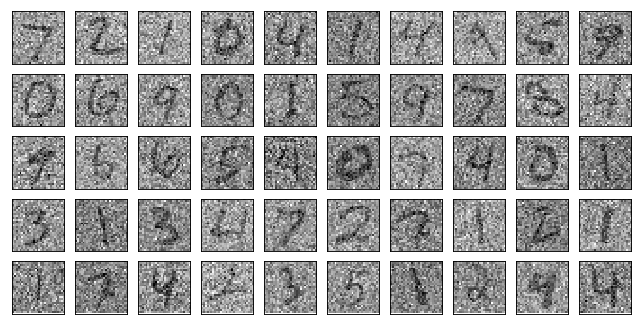

восстановленные данные


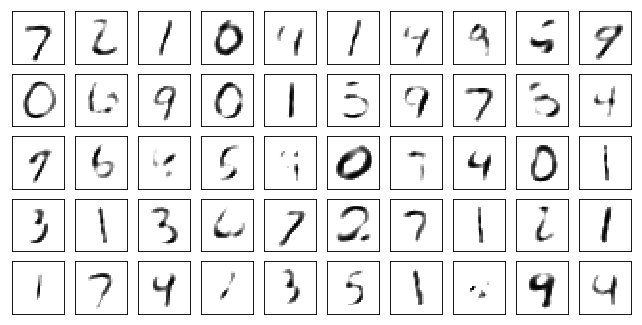

восстановленные данные с упрощенным rho loss


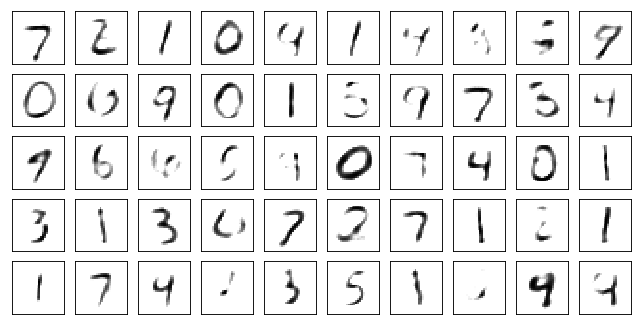

данные на выходе сети с учетом прореживания латентного слоя


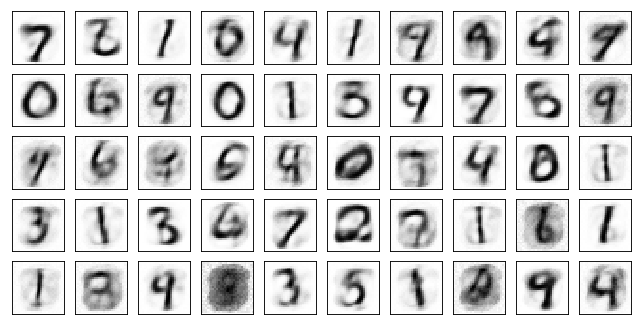

данные на выходе сети с учетом прореживания латентного слоя с упрощенным rho loss


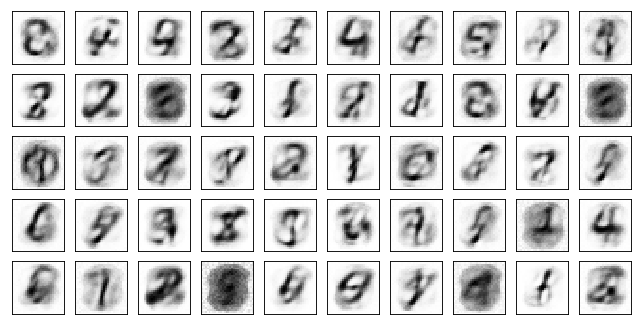

данные на выходе сети при подаче на латентный слой тестовых единичных данных


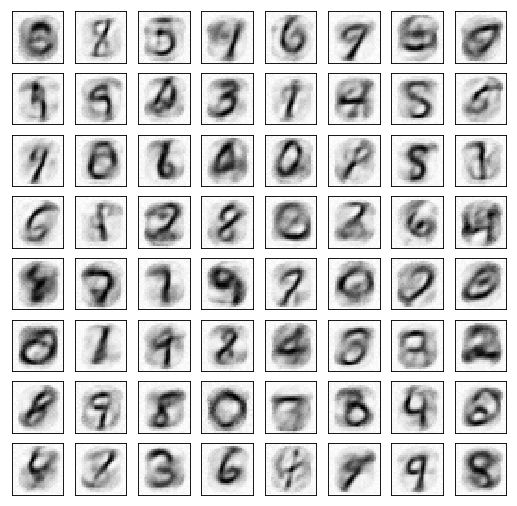

данные на выходе сети при подаче на латентный слой тестовых единичных данных с упрощенным rho loss


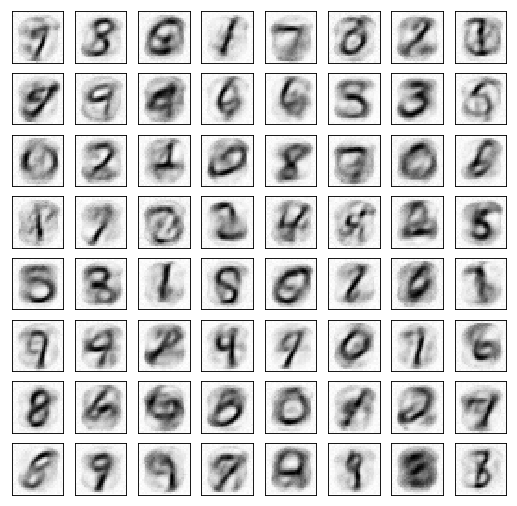

In [75]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))
print('восстановленные данные с упрощенным rho loss')
plot_mnist(rho_to_plot, (5, 10))
print('данные на выходе сети с учетом прореживания латентного слоя')
plot_mnist(f_to_plot, (5, 10))
print('данные на выходе сети с учетом прореживания латентного слоя с упрощенным rho loss')
plot_mnist(rho_f_to_plot, (5, 10))
print('данные на выходе сети при подаче на латентный слой тестовых единичных данных')
plot_mnist(dec_to_plot, (8, 8))
print('данные на выходе сети при подаче на латентный слой тестовых единичных данных с упрощенным rho loss')
plot_mnist(rho_dec_to_plot, (8, 8))

In [76]:
models = {'16': Net(16), '32': Net(32), '64': Net(64), 
          '16 simp_rho': Net(16, simple_rho=True), 
          '32 simp_rho': Net(32, simple_rho=True), 
          '64 simp_rho': Net(64, simple_rho=True)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [77]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log, zero_half=True)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 1.015018 32: 0.994487 64: 1.020346 16 simp_rho: 1.028365 32 simp_rho: 1.031110 64 simp_rho: 1.017720
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.896813 32: 0.839571 64: 0.710194 16 simp_rho: 0.907895 32 simp_rho: 0.860326 64 simp_rho: 0.729269
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.857125 32: 0.744560 64: 0.471311 16 simp_rho: 0.867951 32 simp_rho: 0.738257 64 simp_rho: 0.476122
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.796522 32: 0.559469 64: 0.377962 16 simp_rho: 0.804789 32 simp_rho: 0.559712 64 simp_rho: 0.377251
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.701953 32: 0.463536 64: 0.349404 16 simp_rho: 0.709718 32 simp_rho: 0.469571 64 simp_rho: 0.350904
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.594496 32: 0.401448 64: 0.321023 16 simp_rho: 0.595566 32 simp_rho: 0.408415 64 simp_rho: 0.320289
Test set:
16: loss: 0.5914	rho_loss: 0.0018
32: loss: 0.3915	rho_loss: 0.0026
64: loss: 0.3073	rho_loss: 0.0022
16 simp_rh

Train Epoch: 8 [30000/50000 (60%)]	Losses 16: 0.212408 32: 0.170517 64: 0.138043 16 simp_rho: 0.215138 32 simp_rho: 0.172254 64 simp_rho: 0.137680
Train Epoch: 8 [40000/50000 (80%)]	Losses 16: 0.195532 32: 0.156460 64: 0.130137 16 simp_rho: 0.196488 32 simp_rho: 0.159382 64 simp_rho: 0.131402
Train Epoch: 8 [50000/50000 (100%)]	Losses 16: 0.210735 32: 0.169758 64: 0.137179 16 simp_rho: 0.211523 32 simp_rho: 0.170046 64 simp_rho: 0.135170
Test set:
16: loss: 0.2053	rho_loss: 0.0006
32: loss: 0.1662	rho_loss: 0.0005
64: loss: 0.1341	rho_loss: 0.0004
16 simp_rho: loss: 0.2060	rho_loss: 0.0046
32 simp_rho: loss: 0.1679	rho_loss: 0.0044
64 simp_rho: loss: 0.1343	rho_loss: 0.0043

Train Epoch: 9 [0/50000 (0%)]	Losses 16: 0.213852 32: 0.175297 64: 0.143368 16 simp_rho: 0.215396 32 simp_rho: 0.172759 64 simp_rho: 0.144032
Train Epoch: 9 [10000/50000 (20%)]	Losses 16: 0.209974 32: 0.166053 64: 0.134911 16 simp_rho: 0.207747 32 simp_rho: 0.166877 64 simp_rho: 0.131264
Train Epoch: 9 [20000/50000

Test set:
16: loss: 0.1740	rho_loss: 0.0003
32: loss: 0.1402	rho_loss: 0.0003
64: loss: 0.1115	rho_loss: 0.0002
16 simp_rho: loss: 0.1754	rho_loss: 0.0043
32 simp_rho: loss: 0.1417	rho_loss: 0.0042
64 simp_rho: loss: 0.1119	rho_loss: 0.0042

Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.170553 32: 0.133047 64: 0.105816 16 simp_rho: 0.171940 32 simp_rho: 0.136029 64 simp_rho: 0.106756
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.176680 32: 0.142626 64: 0.115705 16 simp_rho: 0.177750 32 simp_rho: 0.141082 64 simp_rho: 0.113013
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.166958 32: 0.133835 64: 0.107058 16 simp_rho: 0.165867 32 simp_rho: 0.135499 64 simp_rho: 0.105113
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.188535 32: 0.148968 64: 0.120605 16 simp_rho: 0.188815 32 simp_rho: 0.147681 64 simp_rho: 0.119531
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.177047 32: 0.141395 64: 0.112524 16 simp_rho: 0.175677 32 simp_rho: 0.140091 64 simp_rho: 0.113192
Train Epoch: 16 [50000/

In [78]:
data, _ = next(iter(test_loader))
data[:, :, :, :14] = 0
output = models['64'](data)
output_rho = models['64 simp_rho'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy() #данные с выхода сети
rho_to_plot = output_rho.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64)) # подаем на вход декодера тестовые данные
decoded_rho = models['64 simp_rho'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход сети на тестовых данных
rho_dec_to_plot = ((decoded_rho.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28)) #подаем данные на кодер
    encoded_rho = models['64 simp_rho'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1)) # проверяем количество нейронов, преодолевшишх порог 0,5
    print((encoded_rho > 0.5).sum(1))
    encoded[encoded < 0.5] = 0. # прореживаем нейроны не преодолевшие порог
    encoded_rho[encoded_rho < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    rho_decoded_f = models['64 simp_rho'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy() #смотрим выход прореженной сети
    rho_f_to_plot = ((rho_decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([2, 2, 1, 4, 3, 3, 1, 1, 4, 2, 3, 2, 3, 6, 3, 2, 3, 4, 3, 2, 3, 2, 3, 2,
        2, 5, 2, 3, 3, 3, 2, 1, 4, 3, 4, 3, 2, 2, 1, 3, 4, 2, 3, 1, 1, 4, 6, 1,
        5, 4])
tensor([3, 3, 2, 3, 3, 3, 2, 2, 3, 1, 5, 2, 2, 6, 4, 2, 2, 3, 3, 3, 2, 5, 2, 2,
        1, 3, 2, 4, 5, 5, 3, 5, 2, 4, 1, 3, 2, 4, 0, 2, 2, 1, 2, 1, 3, 3, 3, 0,
        5, 4])


исходные данные


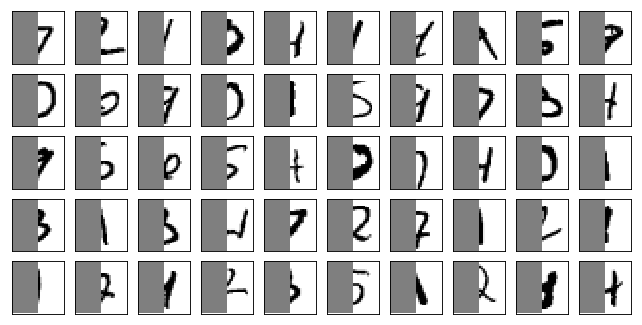

восстановленные данные


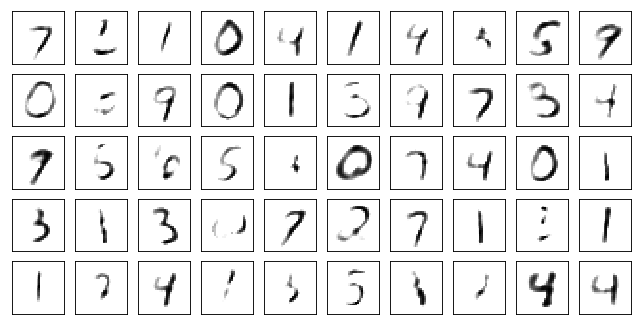

восстановленные данные с упрощенным rho loss


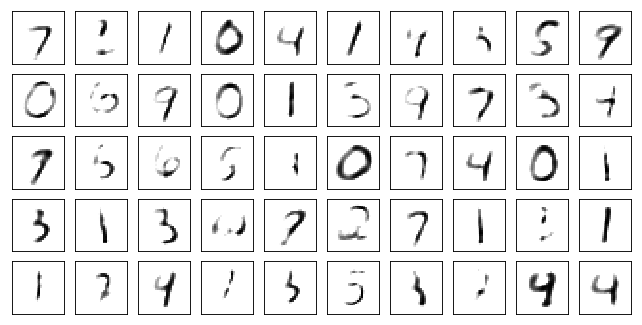

данные на выходе сети с учетом прореживания латентного слоя


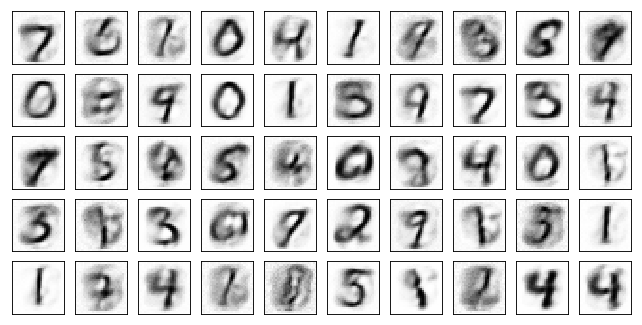

данные на выходе сети с учетом прореживания латентного слоя с упрощенным rho loss


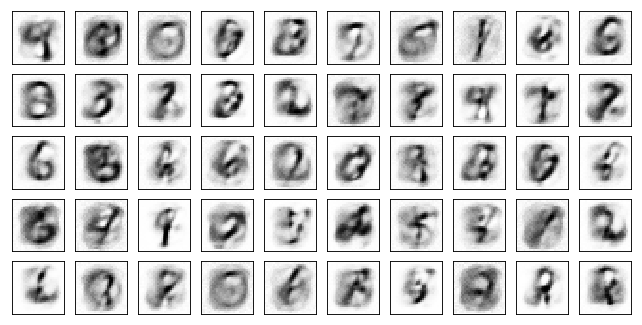

данные на выходе сети при подаче на латентный слой тестовых единичных данных


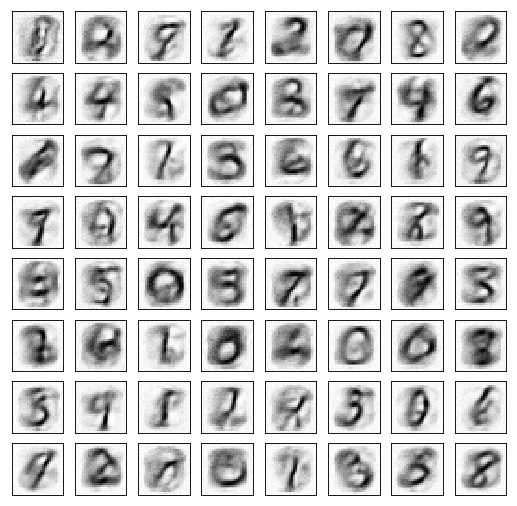

данные на выходе сети при подаче на латентный слой тестовых единичных данных с упрощенным rho loss


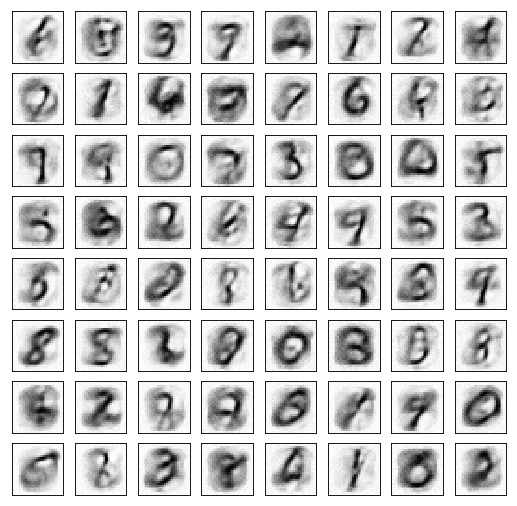

In [79]:
print('исходные данные')
plot_mnist(data.data.numpy(), (5, 10))
print('восстановленные данные')
plot_mnist(to_plot, (5, 10))
print('восстановленные данные с упрощенным rho loss')
plot_mnist(rho_to_plot, (5, 10))
print('данные на выходе сети с учетом прореживания латентного слоя')
plot_mnist(f_to_plot, (5, 10))
print('данные на выходе сети с учетом прореживания латентного слоя с упрощенным rho loss')
plot_mnist(rho_f_to_plot, (5, 10))
print('данные на выходе сети при подаче на латентный слой тестовых единичных данных')
plot_mnist(dec_to_plot, (8, 8))
print('данные на выходе сети при подаче на латентный слой тестовых единичных данных с упрощенным rho loss')
plot_mnist(rho_dec_to_plot, (8, 8))